# Building Agent with LangGraph

## The Simplest Graph

Let's build a simple graph with 3 nodes and one conditional edge. 

![Screenshot 2024-08-20 at 3.11.22 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dba5f465f6e9a2482ad935_simple-graph1.png)

### State

First, define the [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of the graph. 

The State schema serves as the input schema for all Nodes and Edges in the graph.

It can be defined using any Python type, but is typically a TypedDict or Pydantic BaseModel.
Let's use the `BaseModel` class here.

In [1]:
from pydantic import BaseModel


class State(BaseModel):
    graph_state: str

### Nodes

[Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) are just python functions.

The first positional argument is the state, as defined above.

Because the state is a `TypedDict` with schema as defined above, each node can access the key, `graph_state`, with `state['graph_state']`.

Each node returns a new value of the state key `graph_state`.
  
By default, the new value returned by each node [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior state value.

In [2]:
def node_1(state: State):
    print("---Node 1---")
    return {"graph_state": state.graph_state + " I am"}


def node_2(state: State):
    print("---Node 2---")
    return {"graph_state": state.graph_state + " happy!"}


def node_3(state: State):
    print("---Node 3---")
    return {"graph_state": state.graph_state + " sad!"}

In [3]:
from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

### Edges

[Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges) connect the nodes.

Normal Edges are used if you want to *always* go from, for example, `node_1` to `node_2`.

[Conditional Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges) are used if you want to *optionally* route between nodes.
 
Conditional edges are implemented as functions that return the next node to visit based upon some logic.

In [4]:
import random
from typing import Literal


def decide_mood(state) -> Literal["node_2", "node_3"]:

    # Often, we will use state to decide on the next node to visit
    user_input = state.graph_state

    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"

    # 50% of the time, we return Node 3
    return "node_3"

In [5]:
# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

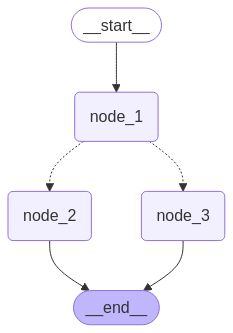

In [6]:
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

### Graph Invocation

The compiled graph implements the [runnable](https://python.langchain.com/docs/concepts/runnables/) protocol.

This provides a standard way to execute LangChain components. 
 
`invoke` is one of the standard methods in this interface.

The input is a dictionary `{"graph_state": "Hi, this is lance."}`, which sets the initial value for our graph state dict.

When `invoke` is called, the graph starts execution from the `START` node.

It progresses through the defined nodes (`node_1`, `node_2`, `node_3`) in order.

The conditional edge will traverse from node `1` to node `2` or `3` using a 50/50 decision rule. 

Each node function receives the current state and returns a new value, which overrides the graph state.

The execution continues until it reaches the `END` node.

In [7]:
graph.invoke({"graph_state": ""})

---Node 1---
---Node 3---


{'graph_state': ' I am sad!'}

## Simple Agent with Function Calling tool

Now, we can extend this into a generic agent architecture.


In the function calling notebook, we explored invoked the model and, if it chose to call a tool, we returned a `ToolMessage` to the user.
 
![Screenshot 2024-08-21 at 12.45.43 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0b4a2c1e5e02f3e78b_agent2.png)

In [8]:
from langchain_google_vertexai import ChatVertexAI, VertexAI, VertexAIEmbeddings

llm = ChatVertexAI(model="gemini-2.0-flash")

In [9]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


# This will be a tool


def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


tools = [add, multiply, divide]

llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [10]:
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState

# System message
sys_msg = SystemMessage(
    content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
)

# Node


def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

For state, we use a prebuilt `MessagesState` which has 'messages' property, and define a `Tools` node with our list of tools.

The `assistant` node is just our model with bound tools.

We create a graph with `assistant` and `tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `tools` based on  whether the `assistant` calls a tool.

Now, we add one new step:

We connect the `Tools` node *back* to the `Assistant`, forming a loop.

* After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
* If it is a tool call, the flow is directed to the `tools` node.
* The `tools` node connects back to `assistant`.
* This loop continues as long as the model decides to call tools.
* If the model response is not a tool call, the flow is directed to END, terminating the process.

In [11]:
from IPython.display import Image, display
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

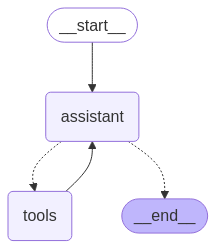

In [12]:
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [13]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3.")}

# thread = {"configurable": {"thread_id": "1"}}

for event in react_graph.stream(initial_input, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3.
================================== Ai Message ==================================
Tool Calls:
  multiply (693b6c1e-cb0d-450b-b494-202905b5e6fe)
 Call ID: 693b6c1e-cb0d-450b-b494-202905b5e6fe
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The product of 2 and 3 is 6.


## Breakpoint and Human-in-the-loop

In [14]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

react_graph = builder.compile(checkpointer=memory, interrupt_before=["tools"])

thread = {"configurable": {"thread_id": "1"}}

for event in react_graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3.
================================== Ai Message ==================================
Tool Calls:
  multiply (04b4d8af-f6f1-4686-80fb-187e1a8437e2)
 Call ID: 04b4d8af-f6f1-4686-80fb-187e1a8437e2
  Args:
    b: 3.0
    a: 2.0


In [15]:
# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in react_graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":

    # If approved, continue the graph execution
    for event in react_graph.stream(None, thread, stream_mode="values"):
        event["messages"][-1].pretty_print()

else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Multiply 2 and 3.
================================== Ai Message ==================================
Tool Calls:
  multiply (dcbd4eef-410d-4c13-9e8e-139f6801bf66)
 Call ID: dcbd4eef-410d-4c13-9e8e-139f6801bf66
  Args:
    b: 3.0
    a: 2.0


Do you want to call the tool? (yes/no):  yes


================================== Ai Message ==================================
Tool Calls:
  multiply (dcbd4eef-410d-4c13-9e8e-139f6801bf66)
 Call ID: dcbd4eef-410d-4c13-9e8e-139f6801bf66
  Args:
    b: 3.0
    a: 2.0
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The answer is 6.
